# HW 2 - Naive Bayes in Hadoop MR
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In the live sessions for week 2 and week 3 you got some practice designing and debugging Hadoop Streaming jobs. In this homework we'll use Hadoop MapReduce to implement your first parallelized machine learning algorithm: Naive Bayes. As you develop your implementation you'll test it on a small dataset that matches the 'Chinese Example' in the _Manning, Raghavan and Shutze_ reading for Week 2. For the main task in this assignment you'll be working with a small subset of the Enron Spam/Ham Corpus. By the end of this assignment you should be able to:
* __... describe__ the Naive Bayes algorithm including both training and inference.
* __... perform__ EDA on a corpus using Hadoop MR.
* __... implement__ parallelized Naive Bayes.
* __... constrast__ partial, unordered and total order sort and their implementations in Hadoop Streaming.
* __... explain__ how smoothing affects the bias and variance of a Multinomial Naive Bayes model.

As always, your work will be graded both on the correctness of your output and on the clarity and design of your code. __Please refer to the `README` for homework submission instructions.__ 

## Notebook Setup
Before starting, run the following cells to confirm your setup.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# global vars (paths) - ADJUST AS NEEDED
JAR_FILE = "/usr/lib/hadoop-mapreduce/hadoop-streaming.jar"
HDFS_DIR = "/user/root/HW2/"
HOME_DIR = "" # FILL IN HERE eg. /media/notebooks/Assignments/HW2

In [3]:
# save path for use in Hadoop jobs (-cmdenv PATH={PATH})
from os import environ
PATH  = environ['PATH']

In [4]:
# data path
ENRON = "data/enronemail_1h.txt"

In [5]:
# make the HDFS directory if it doesn't already exist
!hdfs dfs -ls 
!hdfs dfs -mkdir {HDFS_DIR}

Found 1 items
drwxr-xr-x   - root supergroup          0 2021-09-19 02:09 HW2
mkdir: `/user/root/HW2': File exists


# Question 1: Hadoop MapReduce Key Takeaways.  

This assignment will be the only one in which you use Hadoop Streaming to implement a distributed algorithm. The key reason we continue to teach Hadoop streaming is because of the way it forces the programmer to think carefully about what is happening under the hood when you parallelize a calculation. This question will briefly highlight some of the most important concepts that you need to understand about Hadoop Streaming and MapReduce before we move on to Spark next week.   

### Q1 Tasks:

* __a) short response:__ What "programming paradigm" is Hadoop MapReduce based on? What are the main ideas of this programming paradigm and how does MapReduce exemplify these ideas?

* __b) short response:__ What is the Hadoop Shuffle? When does it happen? Why is it potentially costly? Describe one specific thing we can we do to mitigate the cost associated with this stage of our Hadoop Streaming jobs.

* __c) short response:__ In Hadoop Streaming why do the input and output record format of a combiner script have to be the same? [__`HINT`__ _what level of combining does the framework guarantee? what is the relationship between the record format your mapper emits and the format your reducer expects to receive?_]

* __d) short response:__ To what extent can you control the level of parallelization of your Hadoop Streaming jobs? Please be specific.

* __e) short response:__ What change in the kind of computing resources available prompted the creation of parallel computation frameworks like Hadoop? 

### Q1 Student Answers:

> __a)__ 

The "programming paradigm" that Hadoop MapReduce is based on is functional parallel distributed processing of large data sets. MapReduce is based on the functional programing paradigm as it is a declarative programming paradigm, which means programming is done with expressions. In functional code, the output value of a function depends only on the arguments that are input to the function. Key ideas in this paradigm include avoiding state changes/mutable data, and using higher-order functions (functions which take other functions as inputs. Map and reduce are examples of higher-order functions. Furthermore, there are two primary components at the core of Hadoop: the Hadoop Distributed File System (HDFS) and the MapReduce parallel processing framework. These are both open source projects, inspired by technologies created inside Google. The main idea of this programming paradigm is to take big data and use parallel distributed computing to turn big data problems into smaller sized data problems. This is done through MapReduce by converting the data into sets of tuples, and then combining and reducing those tuples into smaller sets of tuples. Thus, MapReduce exemplifies the programming paradigm by allowing data to be processed in parallel.

> __b)__  

In Hadoop, the process by which the intermediate output from mappers is transferred to the reducer is referred to as the "Hadoop Shuffle". The "Shuffle" phase in Hadoop transfers the map output from a Mapper to a Reducer in MapReduce. The "Sort" phase in MapReduce covers the merging and sorting of map outputs. Data from the mapper are grouped by the key, split among reducers and sorted by the key. This is potentially costly because every reducer obtains all values associated with the same key. The reducer gets 1 or more keys and associated values on the basis of reducers. Then, intermediated key-values generated by the mapper are sorted automatically by the key. In a distributed system, this moving of data between nodes results in network, memory and disk costs which slow down the computation. So, in order to mitigate these issues, we can manually set and increase the number of reducers in the framework. Also, we can utilize a combiner script to help process the data between the mapper and reducer tasks.

> __c)__ 

A combiner is a semi-reducer in the MapReduce framework. This is an optional class which can be specified in the MapReduce driver class to process the output of the mapper before submitting it to the reducer. In the MapReduce framework, usually the output from the mapper is large and the data transfer between the mapper and the reduceer will be high. Thus, combiner scripts summarize the map output records with the same input and output record format, which then helps to reduce the size of the task.

> __d)__ 

We can control the level of parallelization of our Hadoop Streaming jobs. However, we cannot set the number of mappers explicitly to a certain number which is less than the number of mappers calculated by Hadoop. This is decided by the number of Input Splits created by hadoop for our given set of input data. Yet, we may control this by setting the 'mapred' attribute in our framework. So, in order to control the Number of Mappers, which sets the level of parallelization, we have to first control the Number of Input Splits that Hadoop creates before running the MapReduce program. This can be accomplished by setting the property 'mapred.max.split'.

> __e)__ 

Hadoop is an open source framework, written in Java for storing and processing of huge datasets with the cluster of commodity hardware. There are mainly two problems with big data. First one is to store such a huge amount of data and the second one is to process that stored data. So Hadoop provided a solution to the problem of big data i.e. storing and processing the big data with some extra capabilities. There are mainly two components of Hadoop which are Hadoop Distributed File System (HDFS) and the MapReduce framework. Hadoop's MapReduce and HDFS components originally derived respectively from Google's MapReduce and Google File System (GFS) papers. Collectively, these computing resources became available, which then prompted the creation of parallel computation frameworks like Hadoop.


# Question 2: MapReduce Design Patterns.  

In the last two live sessions and in your readings from Lin & Dyer you encountered a number of techniques for manipulating the logistics of a MapReduce implementation to ensure that the right information is available at the right time and location. In this question we'll review a few of the key techniques you learned.   

### Q2 Tasks:

* __a) short response:__ What are counters (in the context of Hadoop Streaming)? How are they useful? What kinds of counters does Hadoop provide for you? How do you create your own custom counter?

* __b) short response:__ What are composite keys? How are they useful? How are they related to the idea of custom partitioning?

* __c) short response:__ What is the order inversion pattern? What problem does it help solve? How do we implement it? 

### Q2 Student Answers:

> __a)__ 

In Hadoop, a named counter is an object that tracks the progress of a MapReduce job. Counters represent global counters, defined either by the MapReduce framework or applications. Hadoop Counters provide a way to measure the progress or the number of operations that occur within the MapReduce framework. Counters are a useful channel for gathering statistics about the MapReduce job: for quality control or for application-level. Counters are also useful for problem diagnosis. They can validate that the framework reads/writes the correct number of bytes or has launched and successfully run the correct number of tasks or not. Counters can also validate that the amount of CPU and memory consumed is appropriate for the job and cluster nodes or not. There are two types of MapReduce counters: Built-in Counters or User-Defined Counters/Custom counters. The different types of built-in counters include MapReduce Task Counter, File System Counters, FileInputFormat Counters, FileOutputFormat counters, Job Counters in MapReduce, and Dynamic Counters in Hadoop. In addition to built-in counters, Hadoop MapReduce permits user code to define a set of counters. Then it increments them as desired in the mapper or reducer. Like in Java, a user can define counters by using ‘enum’.

> __b)__   

A composite key is a candidate key that consists of two or more attributes (table columns) that together uniquely identify an entity occurrence (table row). In complex operations where we require multi column operation, a composite key is very useful. Composite keys are especially useful anytime you need to selectively treat a group of objects that are part of a hierarchy as "the same" when they are in fact different. Furthermore, composite partition keys are used when the data stored is too large to reside in a single partition. Using more than one column for the partition key breaks the data into chunks, or buckets. This is related to custom partitioning as a composite key is just a partition key with more than one column used in the calculation, which then helps to split/partition the data into different groups.

> __c)__ 

The Order Inversion pattern can be used to control the order of reducer values in the MapReduce framework. This is useful because some computations require ordered data. The sole purpose of using the OI pattern is to properly sequence data presented to the reducer. This is because the order inversion pattern exploits the sorting phase of MapReduce to push data needed for calculations to the reducer ahead of the data that will be manipulated. Typically, the OI pattern is applied during the data analysis phase. In Hadoop, the order of values arriving at a reducer is undefined - there is no order unless we exploit the sorting phase of MapReduce to push the data needed for calculations to the reducer. The OI pattern works for pair patterns, which use simpler data structures and require less reducer memory, due to the fact that there is no additional sorting and ordering of reducer values in the reducer phase. The order inversion pattern can be implemented by creating an additional key-value pair with a dummy value that would guarantee that the framework would sort the data in a particular order. For example, in addition to the usual ((key, value), count), the mapper also emits another record ((key, dummy), count). The former will be used to compute f(key, value), while the latter will be used to compute f(key). By decoupling these computations, MapReduce’s property of executing the reducer in key order can now be exploited to control the order in which the data is processed.


# Question 3: Understanding Total Order Sort

The key challenge in distributed computing is to break a problem into a set of sub-problems that can be performed without communicating with each other. Ideally, we should be able to define an arbirtary number of splits and still get the right result, but that is not always possible. Parallelization becomes particularly challenging when we need to make comparisons between records, for example when sorting. Total Order Sort allows us to order large datasets in a way that enables efficient retrieval of results. Before beginning this assignment, make sure you have read and understand the [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb). You can skip the first two MRJob sections, but the rest of section III and all of section IV are **very** important (and apply to Hadoop Streaming) so make sure to read them closely. Feel free to read the Spark sections as well but you won't be responsible for that material until later in the course. To verify your understanding, answer the following questions.

### Q3 Tasks:

* __a) short response:__ What is the difference between a partial sort, an unordered total sort, and a total order sort? From the programmer's perspective, what does total order sort allow us to do that we can't with unordered total? Why is this important with large datasets?

* __b) short response:__ Which phase of a MapReduce job is leveraged to implement Total Order Sort? Which default behaviors must be changed. Why must they be changed?

* __c) short response:__ Describe in words how to configure a Hadoop Streaming job for the custom sorting and partitioning that is required for Total Order Sort.  

* __d) short response:__ Explain why we need to use an inverse hash code function.

* __e) short response:__ Where does this function need to be located so that a Total Order Sort can be performed?

### Q3 Student Answers:

> __a)__ 

A partial sort is when the reducer output will consist of a lot of partitioned files, each of which contains key-value records that are sorted within each partition file based on the key. This is the default behavior for the MapReduce framework in Hadoop. So, the reducer output will be a lot of files each of which is sorted within itself based on the key. An unordered total sort refers to an ordering of all key-value pairs based upon a specified key. This total ordering will run across all output partition files, unlike the partial sort. The reducer output will be a single file having all the output sorted based on the key. A total order sort is where the partition file names are also assigned in order. The objective of Total Order Sorting is to have all outputs sorted across all reducers. Compared to the unordered total sort, a total order sort allows us to have all the outputs sorted across all reducers. This is important with large datasets because, this way, the outputs can be read/searched/concatenated sequentially as a single ordered output.

> __b)__ 

In order to implement the total order sort, the Hadoop framework samples the input data to pre-calculate how to “separate” the input data into equal parts before the Mapper phase starts. It then uses those “separations” as partitioning boundaries during the mapper’s partitioning phase. So, sorting uses the map output keys to calculate partitioning. In the MapReduce algorithm, when using multiple reducers, each reducer receives (key,value) pairs assigned to them by the Partitioner. When a reducer receives those pairs they are sorted by key, so generally the output of a reducer is also sorted by key. However, the outputs of different reducers are not ordered between each other, so they cannot be concatenated or read sequentially in the correct order. This default behavior must be changed in order to produce results that can be read/searched/concatenated sequentially as a single ordered output.

> __c)__  

In order to configure a Hadoop Streaming job for the custom sorting and partitioning that is required for Total Order Sort, there are several steps we need to implement. First, an input sampler function must sample keys across all input splits and sort them using the job’s Sort Comparator. Second, the input sampler then writes a “partition file” in HDFS, which delimits the different partition boundaries based on the sorted samples. For n reducers there are n-1 boundaries written to this file. Third, the MapReduce job begins with the mapper tasks. For partitioning, the mappers use the total order sorting, which will read the partition file from HDFS to obtain partition boundaries. Each map output is then stored in a partition based on these boundaries. Fourth, after the shuffle, each reducer will fetch a sorted partition of (key,value) pairs from each mapper. At this point, all keys in the last reducer are alphabetically greater than all keys in prior reducers. Each reducer then merges their sorted partitions (using a sorted merge-queue) and writes their output to HDFS.


> __d)__ 

In the MapReduce framework, we need to use an inverse hash code function. This is because it allows us to preserve partition key ordering. So, we can construct an inverse hash code function which takes as input the desired partition index and total number of partitions, which would then return a partition key. This key, when supplied to the Hadoop framework, will hash to the correct partition index.

> __e)__ 

The inverse hash code function needs to be located in the mapper phase so that total order sort can be performed. That way, while in the mapper stage, if we want to assign a record to a given partition, we can simply look at the partition key that was generated for the partition.

# About the Data
For the main task in this portion of the homework you will train a classifier to determine whether an email represents spam or not. You will train your Naive Bayes model on a 100 record subset of the Enron Spam/Ham corpus available in the HW2 data directory (__`HW2/data/enronemail_1h.txt`__).

__Source:__   
The original data included about 93,000 emails which were made public after the company's collapse. There have been a number raw and preprocessed versions of this corpus (including those available [here](http://www.aueb.gr/users/ion/data/enron-spam/index.html) and [here](http://www.aueb.gr/users/ion/publications.html)). The subset we will use is limited to emails from 6 Enron employees and a number of spam sources. It is part of [this data set](http://www.aueb.gr/users/ion/data/enron-spam/) which was created by researchers working on personlized Bayesian spam filters. Their original publication is [available here](http://www.aueb.gr/users/ion/docs/ceas2006_paper.pdf). __`IMPORTANT!`__ _For this homework please limit your analysis to the 100 email subset which we provide. No need to download or run your analysis on any of the original datasets, those links are merely provided as context._

__Preprocessing:__  
For their work, Metsis et al. (the authors) appeared to have pre-processed the data, not only collapsing all text to lower-case, but additionally separating "words" by spaces, where "words" unfortunately include punctuation. As a concrete example, the sentence:  
>  `Hey Jon, I hope you don't get lost out there this weekend!`  

... would have been reduced by Metsis et al. to the form:  
> `hey jon , i hope you don ' t get lost out there this weekend !` 

... so we have reverted the data back toward its original state, removing spaces so that our sample sentence would now look like:
> `hey jon, i hope you don't get lost out there this weekend!`  

Thus we have at least preserved contractions and other higher-order lexical forms. However, one must be aware that this reversion is not complete, and that some object (specifically web sites) will be ill-formatted, and that all text is still lower-cased.


__Format:__   
All messages are collated to a tab-delimited format:  

>    `ID \t SPAM \t SUBJECT \t CONTENT \n`  

where:  
>    `ID = string; unique message identifier`  
    `SPAM = binary; with 1 indicating a spam message`  
    `SUBJECT = string; title of the message`  
    `CONTENT = string; content of the message`   
    
Note that either of `SUBJECT` or `CONTENT` may be "NA", and that all tab (\t) and newline (\n) characters have been removed from both of the `SUBJECT` and `CONTENT` columns.  

In [6]:
!pwd

/media/notebooks/Assignments/HW2


In [7]:
# take a look at the first 100 characters of the first 5 records (RUN THIS CELL AS IS)
!head -n 5 /media/notebooks/Assignments/HW2/{ENRON} | cut -c-100

0001.1999-12-10.farmer	0	 christmas tree farm pictures	NA
0001.1999-12-10.kaminski	0	 re: rankings	 thank you.
0001.2000-01-17.beck	0	 leadership development pilot	" sally:  what timing, ask and you shall receiv
0001.2000-06-06.lokay	0	" key dates and impact of upcoming sap implementation over the next few week
0001.2001-02-07.kitchen	0	 key hr issues going forward	 a) year end reviews-report needs generating 


In [8]:
# see how many messages/lines are in the file 
#(this number may be off by 1 if the last line doesn't end with a newline)
!wc -l /media/notebooks/Assignments/HW2/{ENRON}

100 /media/notebooks/Assignments/HW2/data/enronemail_1h.txt


In [9]:
# make the HDFS directory if it doesn't already exist
!hdfs dfs -mkdir {HDFS_DIR}

mkdir: `/user/root/HW2': File exists


In [10]:
# load the data into HDFS (RUN THIS CELL AS IS)
!hdfs dfs -copyFromLocal /media/notebooks/Assignments/HW2/{ENRON} {HDFS_DIR}/enron.txt

copyFromLocal: `/user/root/HW2/enron.txt': File exists


In [11]:
!hdfs dfs -ls {HDFS_DIR}

Found 14 items
drwxr-xr-x   - root supergroup          0 2021-09-19 01:08 /user/root/HW2/chinese-NB-output
drwxr-xr-x   - root supergroup          0 2021-09-19 01:50 /user/root/HW2/chinese-NBsmooth-output
drwxr-xr-x   - root supergroup          0 2021-09-19 01:49 /user/root/HW2/chinese-NBsmooth-size-output
drwxr-xr-x   - root supergroup          0 2021-09-19 01:07 /user/root/HW2/chinese-output
-rw-r--r--   1 root supergroup        119 2021-09-19 01:06 /user/root/HW2/chineseTest.txt
-rw-r--r--   1 root supergroup        107 2021-09-19 01:06 /user/root/HW2/chineseTrain.txt
drwxr-xr-x   - root supergroup          0 2021-09-19 01:52 /user/root/HW2/enron-NBsmooth-size-output
-rw-r--r--   1 root supergroup     204559 2021-09-19 01:06 /user/root/HW2/enron.txt
-rw-r--r--   1 root supergroup      41493 2021-09-19 01:52 /user/root/HW2/enron_test.txt
-rw-r--r--   1 root supergroup     163066 2021-09-19 01:52 /user/root/HW2/enron_train.txt
drwxr-xr-x   - root supergroup          0 2021-09-19 01:55

# Question 4:  Enron Ham/Spam EDA.
Before building our classifier, lets get aquainted with our data. In particular, we're interested in which words occur more in spam emails than in legitimate ("ham") emails. In this question you'll implement two Hadoop MapReduce jobs to count and sort word occurrences by document class. You'll also learn about two new Hadoop streaming parameters that will allow you to control how the records output from your mappers are partitioned for reducing on separate nodes. 

__`IMPORTANT NOTE:`__ For this question and all subsequent items, you should include both the subject and the body of the email in your analysis (i.e. concatetate them to get the 'text' of the document).

### Q4 Tasks:
* __a) code:__ Complete the missing components of the code in __`EnronEDA/mapper.py`__ and __`EnronEDA/reducer.py`__ to create a Hadoop  MapReduce job that counts how many times each word in the corpus occurs in an email for each class. Pay close attention to the data format specified in the docstrings of these scripts _-- there are a number of ways to accomplish this task, we've chosen this format to help illustrate a technique in `part e`_. Run the provided unit tests to confirm that your code works as expected, then run the provided Hadoop Streaming command to apply your analysis to the Enron data.


* __b) code + short response:__ How many times does the word "__assistance__" occur in each class? (`HINT:` Use a `grep` command to read from the results file you generated in '`a`' and then report the answer in the space provided.)


* __c) short response:__ Would it have been possible to add some sorting parameters to the Hadoop streaming command that would cause our `part a` results to be sorted by count? Explain why or why not. (`HINT:` This question demands an understanding of the sequence of the phases of MapReduce.)


* __d) code + short response:__ Write a second Hadoop MapReduce job to sort the output of `part a` first by class and then by count. Run your job and save the results to a local file. Then describe in words how you would go about printing the top 10 words in each class given this sorted output. (`HINT 1:` _remember that you can simply pass the `part a` output directory to the input field of this job; `HINT 2:` since this task is just reodering the records from `part a` we don't need to write a mapper or reducer, just use `/bin/cat` for both_)


* __e) code:__ A more efficient alternative to '`grep`-ing' for the top 10 words in each class would be to use the Hadoop framework to separate records from each class into its own partition so that we can just read the top lines in each. Rewrite your job from ` part d` to specify 2 reduce tasks and to tell Hadoop to partition based on the second field (which indicates spam/ham in our data). Your code should maintain the secondary sort -- that is each partition should list words from most to least frequent.

### Q4 Student Answers:
> __b)__   

The word "assistance" occurs 2 times in the 'Ham' class and 8 times in the 'Spam' class.

> __c)__ 

It is possible to add some sorting parameters to the Hadoop streaming command in order to sort our results by count. This is because of the sequence of the MapReduce framework. For instance, Hadoop streaming will create a MapReduce job, submit the job to an appropriate cluster, and monitor the progress of the job until it completes. The mapper outputs keys of the  MapReduce job, which normally produces unsorted results. However, the MapReduce framework will sort the outputs by a given field of the keys using the '-D mapred.text.key.comparator.options=-kX,Xnr' option. The custom Comparator does sorting so that the specified key groups the data once it arrives at the reducer from the mapper.

> __d)__ 

In order to print the top 10 words in each class, given this sorted output, I would need several different linux commands. First, I would need to write my results to a text file. Then, I could just use the '!head -10' command to get the top 10 words for the 'Spam' (1) class since the results have already been sorted in that manner. However, in order to get the top 10 words for the 'Ham' (0) class, I would need to use the "awk" command as follows: '!awk '$2 == "0" { print $0 }''. These results can then also be reduced to the top 10 entries using the "head" command.

In [12]:
# part a - do your work in the provided scripts then RUN THIS CELL AS IS
!chmod a+x EnronEDA/mapper.py
!chmod a+x EnronEDA/reducer.py

In [13]:
# part a - unit test EnronEDA/mapper.py (RUN THIS CELL AS IS)
!echo -e "d1	1	title	body\nd2	0	title	body" | EnronEDA/mapper.py

title	1	1
body	1	1
title	0	1
body	0	1


In [14]:
# part a - unit test EnronEDA/reducer.py (RUN THIS CELL AS IS)
!echo -e "one	1	1\none	0	1\none	0	1\ntwo	0	1" | EnronEDA/reducer.py

one	0	2
one	1	1
two	0	1
two	1	0


In [15]:
# part a - clear output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-output

rm: `/user/root/HW2//eda-output': No such file or directory


In [16]:
# part a - Hadoop streaming job (RUN THIS CELL AS IS)
!hadoop jar {JAR_FILE} \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper mapper.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/enron.txt \
  -output {HDFS_DIR}/eda-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob5654121302250421396.jar tmpDir=null
21/09/19 13:43:16 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:43:16 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:43:18 INFO mapred.FileInputFormat: Total input paths to process : 1
21/09/19 13:43:18 INFO mapreduce.JobSubmitter: number of splits:2
21/09/19 13:43:18 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1632058887789_0001
21/09/19 13:43:19 INFO impl.YarnClientImpl: Submitted application application_1632058887789_0001
21/09/19 13:43:19 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1632058887789_0001/
21/09/19 13:43:19 INFO mapreduce.Job: Running job: job_1632058887789_0001
21/09/19 13:43:27 INFO mapreduce.Job: Job job_1632058887789_0001 running in uber mode : false
21/09/19 13:43:27 INFO mapreduce.Job:  map 0% reduce 0%
21/09

In [17]:
# part a - retrieve results from HDFS & copy them into a local file (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/eda-output/part-0000* > EnronEDA/results.txt

In [18]:
# part b - write your grep command here

!grep assistance EnronEDA/results.txt

assistance	0	2
assistance	1	8


In [19]:
# part d - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-sort-output

rm: `/user/root/HW2//eda-sort-output': No such file or directory


In [20]:
# part d - write your Hadoop streaming job here

!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2nr -k3,3nr" \
  -D mapreduce.partition.keypartitioner.options="-k1,1"  \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper /bin/cat \
  -reducer /bin/cat \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/eda-output \
  -output {HDFS_DIR}/eda-sort-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}


packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob2636237258501599025.jar tmpDir=null
21/09/19 13:44:01 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:44:01 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:44:02 INFO mapred.FileInputFormat: Total input paths to process : 2
21/09/19 13:44:02 INFO mapreduce.JobSubmitter: number of splits:2
21/09/19 13:44:02 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1632058887789_0002
21/09/19 13:44:02 INFO impl.YarnClientImpl: Submitted application application_1632058887789_0002
21/09/19 13:44:02 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1632058887789_0002/
21/09/19 13:44:02 INFO mapreduce.Job: Running job: job_1632058887789_0002
21/09/19 13:44:08 INFO mapreduce.Job: Job job_1632058887789_0002 running in uber mode : false
21/09/19 13:44:08 INFO mapreduce.Job:  map 0% reduce 0%
21/09

In [21]:
!hdfs dfs -cat {HDFS_DIR}/eda-sort-output/part-0000* > EnronEDA/sortedresults.txt

In [22]:
#!grep assistance EnronEDA/sortedresults.txt
!head -10 EnronEDA/sortedresults.txt

this	1	143	
is	1	135	
we	1	116	
with	1	116	
are	1	107	
will	1	102	
have	1	101	
our	1	90	
free	1	79	
from	1	78	


In [23]:
!awk '$2 == "0" { print $0 }' EnronEDA/sortedresults.txt | head -10

ect	0	382	
hou	0	206	
will	0	132	
enron	0	127	
this	0	119	
is	0	114	
with	0	85	
as	0	69	
have	0	69	
am	0	67	
awk: (FILENAME=EnronEDA/sortedresults.txt FNR=3203) fatal: print to "standard output" failed (Broken pipe)


In [24]:
# part e - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-sort-output

Deleted /user/root/HW2/eda-sort-output


In [25]:
# part e - write your Hadoop streaming job here

!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2nr -k3,3nr" \
  -D mapreduce.partition.keypartitioner.options="-k2,2nr"  \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper /bin/cat \
  -reducer /bin/cat \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/eda-output \
  -output {HDFS_DIR}/eda-sort-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob1537171774095927079.jar tmpDir=null
21/09/19 13:44:43 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:44:43 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:44:44 INFO mapred.FileInputFormat: Total input paths to process : 2
21/09/19 13:44:44 INFO mapreduce.JobSubmitter: number of splits:2
21/09/19 13:44:44 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1632058887789_0003
21/09/19 13:44:44 INFO impl.YarnClientImpl: Submitted application application_1632058887789_0003
21/09/19 13:44:44 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1632058887789_0003/
21/09/19 13:44:44 INFO mapreduce.Job: Running job: job_1632058887789_0003
21/09/19 13:44:51 INFO mapreduce.Job: Job job_1632058887789_0003 running in uber mode : false
21/09/19 13:44:51 INFO mapreduce.Job:  map 0% reduce 0%
21/09

In [26]:
# part e - view the top 10 records from each partition (RUN THIS CELL AS IS)
for idx in range(2):
    print(f"\n===== part-0000{idx}=====\n")
    !hdfs dfs -cat {HDFS_DIR}/eda-sort-output/part-0000{idx} | head


===== part-00000=====

the	0	549	
to	0	398	
ect	0	382	
and	0	278	
of	0	230	
hou	0	206	
a	0	196	
in	0	182	
for	0	170	
on	0	135	
cat: Unable to write to output stream.

===== part-00001=====

the	1	698	
to	1	566	
and	1	392	
your	1	357	
a	1	347	
you	1	345	
of	1	336	
in	1	236	
for	1	204	
com	1	153	
cat: Unable to write to output stream.


__Expected output:__
<table>
<th>part-00000:</th>
<th>part-00001:</th>
<tr><td><pre>
the	0	549	
to	0	398	
ect	0	382	
and	0	278	
of	0	230	
hou	0	206	
a	0	196	
in	0	182	
for	0	170	
on	0	135
</pre></td>
<td><pre>
the	1	698	
to	1	566	
and	1	392	
your	1	357	
a	1	347	
you	1	345	
of	1	336	
in	1	236	
for	1	204	
com	1	153
</pre></td></tr>
</table>

# Question 5: Counters and Combiners.
Tuning the number of mappers & reducers is helpful to optimize very large distributed computations. Doing so successfully requires a thorough understanding of the data size at each stage of the job. As you learned in the week3 live session, counters are an invaluable resource for understanding this kind of detail. In this question, we will take the EDA performed in Question 4 as an opportunity to illustrate some related concepts.

### Q5 Tasks:
* __a) short response:__ Read the Hadoop output from your job in Question 4a to report how many records are emitted by the mappers and how many records are received be the reducers. In the context of word counting what does this number represent practically?

* __b) code:__ Note that we wrote the reducer in question 4a such that the input and output record format is identical. This makes it easy to use the same reducer script as a combiner. In the space provided below, write the Hadoop Streaming command to re-run your job from question 4a with this combining added.

* __c) short response__: Report the number of records emitted by your mappers in part b and the number of records received by your reducers. Compare your results here to what you saw in part a. Explain.

* __d) short response__: Describe a scenario where using a combiner would _NOT_ improve the efficiency of the shuffle stage. Explain. [__`BONUS:`__ how does increasing the number of mappers affect the usefulness of a combiner?]

### Q5 Student Answers:
> __a)__ 

From our job in Question 4A, the number of Mapper output records is 31490 and the number of Reducer input records is 31490. In the context of word counting, this number practically represents the size of the total word corpus. This means that there are over thirty thousand works to process/count.

> __c)__ 

Now, with the additional combiner script in the Hadoop streaming job, the number of Mapper output records is still 31490, but the number of Reducer input records is now 13096. This is a much smaller input value, which makes sense given that a combiner is an aggregation script that will take mapper output records with the same key and turn them into a single, combined, record prior to the reducer. The combiner effectively preprocessed the data before the reducer.

> __d)__ 

Although combiners are a useful tool, there are scenarios where using one would actually NOT improve the efficiency of the shuffle stage. This is because Combiners can be used only in the case where the reducer function is both commutative and associative. 

- The associative property of addition states that you can group the addends in different ways without changing the outcome. 
- The commutative property of addition states that you can reorder the addends without changing the outcome.

These property requirements are due to the fact that the values are combined locally before being shuffled in an arbitrary order. So, for example, we would not use a combiner in order to calculate the average/mean function - that calcualtion is not associative. 

Also, increasing the number of mappers affects the usefulness of a combiner. The combiner enables Reducer-style functionality on the Mappers in order to decrease the cost of the shuffle-and-sort and the reduce phase. However, while Combiners are an elegant way of adding data reduction functionality to a Map task, they cannot be controlled by the user. In particular, the MapReduce system decides when and on which Map output records the Combiner is executed. So, increasing the number of mappers could impact the combiner utility.

In [27]:
# part b - clear output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-output

Deleted /user/root/HW2/eda-output


In [28]:
# part b - write your Hadoop streaming job here

!hadoop jar {JAR_FILE} \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper mapper.py \
  -combiner reducer.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/enron.txt \
  -output {HDFS_DIR}/eda-combiner-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob1093171924775736290.jar tmpDir=null
21/09/19 13:45:28 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:45:28 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:45:29 INFO mapred.FileInputFormat: Total input paths to process : 1
21/09/19 13:45:30 INFO mapreduce.JobSubmitter: number of splits:2
21/09/19 13:45:30 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1632058887789_0004
21/09/19 13:45:30 INFO impl.YarnClientImpl: Submitted application application_1632058887789_0004
21/09/19 13:45:30 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1632058887789_0004/
21/09/19 13:45:30 INFO mapreduce.Job: Running job: job_1632058887789_0004
21/09/19 13:45:35 INFO mapreduce.Job: Job job_1632058887789_0004 running in uber mode : false
21/09/19 13:45:35 INFO mapreduce.Job:  map 0% reduce 0%
21/09

# Question 6: Document Classification Task Overview.
The week 2 assigned reading from Chapter 13 of _Introduction to Information Retrieval_ by Manning, Raghavan and Schutze provides a thorough introduction to the document classification task and the math behind Naive Bayes. In this question we'll use the example from Table 13.1 (reproduced below) to 'train' an unsmoothed Multinomial Naive Bayes model and classify a test document by hand.

<table>
<th>DocID</th>
<th>Class</th>
<th>Subject</th>
<th>Body</th>
<tr><td>Doc1</td><td>1</td><td></td><td>Chinese Beijing Chinese</td></tr>
<tr><td>Doc2</td><td>1</td><td></td><td>Chinese Chinese Shanghai</td></tr>
<tr><td>Doc3</td><td>1</td><td></td><td>Chinese Macao</td></tr>
<tr><td>Doc4</td><td>0</td><td></td><td>Tokyo Japan Chinese</td></tr>
</table>

### Q6 Tasks:
* __a) short response:__ Equation 13.3 in Manning, Raghavan and Shutze shows how a Multinomial Naive Bayes model classifies a document. It predicts the class, $c$, for which the estimated conditional probability of the class given the document's contents,  $\hat{P}(c|d)$, is greatest. In this equation what two pieces of information are required to calculate  $\hat{P}(c|d)$? Your answer should include both mathematical notatation and verbal explanation.


* __b) short response:__ The Enron data includes two classes of documents: `spam` and `ham` (they're actually labeled `1` and `0`). In plain English, explain what  $\hat{P}(c)$ and   $\hat{P}(t_{k} | c)$ mean in the context of this data. How will we would estimate these values from a training corpus? How many passes over the data would we need to make to retrieve this information for all classes and all words?


* __c) hand calculations:__ Above we've reproduced the document classification example from the textbook (we added an empty subject field to mimic the Enron data format). Remember that the classes in this "Chinese Example" are `1` (about China) and `0` (not about China). Calculate the class priors and the conditional probabilities for an __unsmoothed__ Multinomial Naive Bayes model trained on this data. Show the calculations that lead to your result using markdown and $\LaTeX$ in the space provided or by embedding an image of your hand written work. [`NOTE:` _Your results should NOT match those in the text -- they are training a model with +1 smoothing you are training a model without smoothing_]


* __d) hand calculations:__ Use the model you trained to classify the following test document: `Chinese Chinese Chinese Tokyo Japan`. Show the calculations that lead to your result using markdown and   $\LaTeX$ in the space provided or by embedding an image of your hand written work.


* __e) short response:__ Compare the classification you get from this unsmoothed model in `d`/`e` to the results in the textbook's "Example 1" which reflects a model with Laplace plus 1 smoothing. How does smoothing affect our inference?

### Q6 Student Answers:

> __a)__ 

In the equation, the two pieces of information that are required to calculate  $\hat{P}(c|d)$ are $arg max \hat{P}(c)$ and $\prod \hat{P}(t_k | c)$. In this context $\hat{P}(c)$ is the prior probability of a document occurring in class $c$. Also, we can interpret $\hat{P}(t_k | c)$ as a measure of how much evidence $t_k$ contributes such that $c$ is the correct class, as it represents the relative frequency of term $t$ in documents belonging to class $c$. These values, together, will help us determine our Naive Bayes model results.

> __b)__ 

Naive Bayes is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. In the context of our Enron data, the components represent different aspects of the features: $\hat{P}(c)$ is probability that an email is of class spam or ham and $\hat{P}(t_k|c)$ is the likelihood/probability of the predictor given the spam or ham class.

There are two different steps to calculate these values. For the priors, this calculation is: $\hat{P}(c)$ = $N_c/N$, where $N_c$ is the number of documents in class $c$ and $N$ is the total number of documents. The conditional probability for a feature value given the class label can also be estimated from the data. We estimate the conditional probability $\hat{P}(t_k|c)$ as the relative frequency of term $t$ in documents belonging to class. This is represented as $\hat{P}(t_k|c)$ = 
$T_{ct}/\sum T_{ct}$, where $T_{ct}$ is the number of occurrences of $t$ in training documents from class $c$, including multiple occurrences of a term in a document.

In order to retrieve this information for all classes and all words, the preprocessing necessary for computing the parameters (extracting the vocabulary, counting terms, etc.) can be done in one pass through the training data.



> __c)__ 

Priors: 

$\hat{P}(1) = 3/4$ and $\hat{P}(0) = 1/4$

Conditional Probabilities (Class 1 - China):

$\hat{P}(Chinese | 1) = 5/14$

$\hat{P}(Beijing | 1) = 1/14$

$\hat{P}(Shanghai | 1) = 1/14$

$\hat{P}(Macao | 1) = 1/14$

$\hat{P}(Tokyo | 1) = 0$

$\hat{P}(Japan | 1) = 0$

Conditional Probabilities (Class 0 - Not China):

$\hat{P}(Chinese | 0) = 1/9$

$\hat{P}(Beijing | 0) = 0$

$\hat{P}(Shanghai | 0) = 0$

$\hat{P}(Macao | 0) = 0$

$\hat{P}(Tokyo | 0) = 1/9$

$\hat{P}(Japan | 0) = 1/9$

*Also see attached image.*

> __d)__ 

$\hat{P}(1 | Doc5) = (3/4) * (5/14)^3 * (0) * (0) = 0 $

$\hat{P}(0 | Doc5) = (1/4) * (1/9)^3 * (1/9) * (1/9) = 0.000004 $

*Also see attached image.*

Thus, the classifier assigns the test document to class 0 (Not China).

> __e)__ 

Smoothing affects our inference. This is because, in our model, we did not use smoothing. So, words in the test set that were not represented in the class 1 corpus received a probability of zero. This then impacted our final probability results. Yet, had we used smoothing like in the textbook example, we would not have had zero probabilities and gotten the opposite answer from the classifier. Thus, smoothing can play an important role in our classifier model.


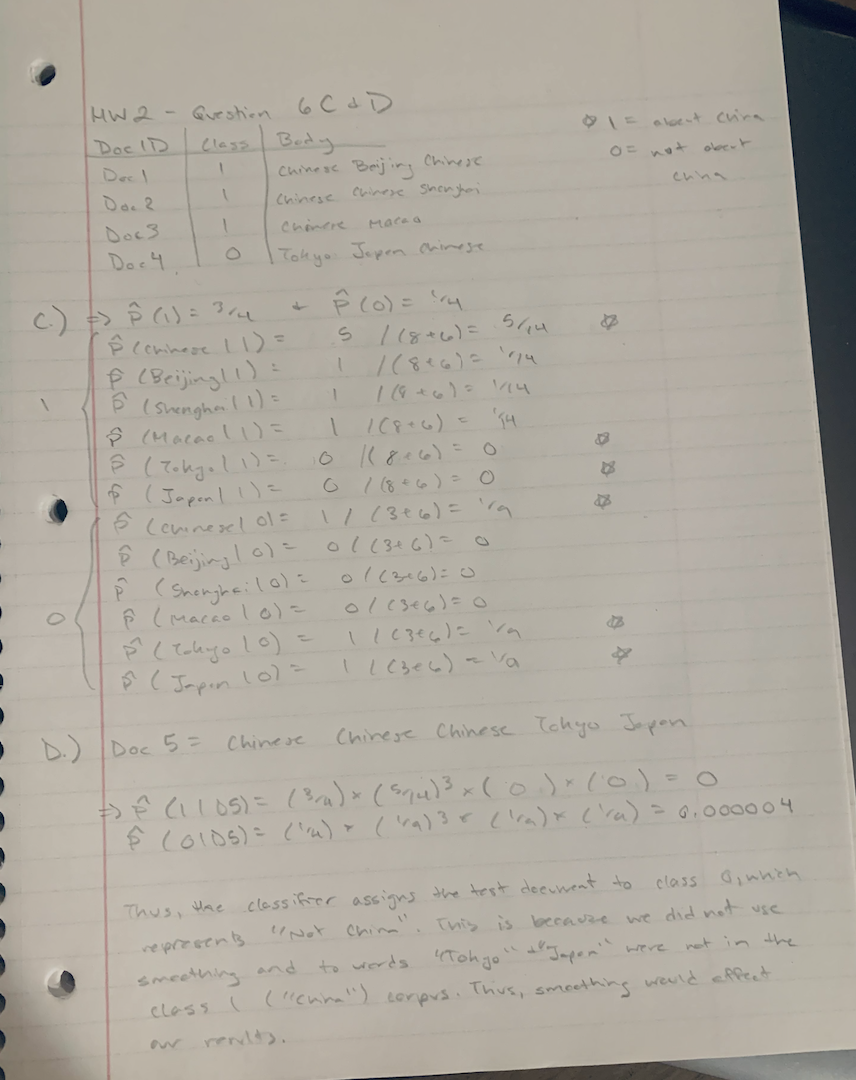

In [29]:
# part d/e - if you didn't write out your calcuations above, embed a picture of them here:
from IPython.display import Image
Image(filename="Question6Response.png")

# Question 7: Naive Bayes Inference.
In the next two questions you'll write code to parallelize the Naive Bayes calculations that you performed above. We'll do this in two phases: one MapReduce job to perform training and a second MapReduce to perform inference. While in practice we'd need to train a model before we can use it to classify documents, for learning purposes we're going to develop our code in the opposite order. By first focusing on the pieces of information/format we need to perform the classification (inference) task you should find it easier to develop a solid implementation for training phase when you get to question 8 below. In both of these questions we'll continue to use the Chinese example corpus from the textbook to help us test our MapReduce code as we develop it. Below we've reproduced the corpus, test set and model in text format that matches the Enron data.

### Q7 Tasks:
* __a) short response:__ run the provided cells to create the example files and load them in to HDFS. Then take a closer look at __`NBmodel.txt`__. This text file represents a Naive Bayes model trained (with Laplace +1 smoothing) on the example corpus. What are the 'keys' and 'values' in this file? Which record means something slightly different than the rest? The value field of each record includes two numbers which will be helpful for debugging but which we don't actually need to perform inference -- what are they? [`HINT`: _This file represents the model from Example 13.1 in the textbook, if you're having trouble getting oriented try comparing our file to the numbers in that example._]


* __b) short response:__ When performing Naive Bayes in practice instead of multiplying the probabilities (as in equation 13.3) we add their logs (as in equation 13.4). Why do we choose to work with log probabilities? If we had an unsmoothed model, what potential error could arise from this transformation?


* __c) short response:__ Documents 6 and 8 in the test set include a word that did not appear in the training corpus (and as a result does not appear in the model). What should we do at inference time when we need a class conditional probability for this word?


* __d) short response:__ The goal of our MapReduce job is to stream over the test set and classify each document by peforming the calculation from equation 13.4. To do this we'll load the model file (which contains the probabilities for equation 13.4) into memory on the nodes where we do our mapping. This is called an in-memory join. Does loading a model 'state' like this depart from the functional programming principles? Explain why or why not. From a scability perspective when would this kind of memory use be justified? when would it be unwise?


* __e) code:__ Complete the code in __`NaiveBayes/classify_mapper.py`__. Read the docstring carefully to understand how this script should work and the format it should return. Run the provided unit tests to confirm that your script works as expected then write a Hadoop streaming job to classify the Chinese example test set. [`HINT 1:` _you shouldn't need a reducer for this one._ `HINT 2:` _Don't forget to add the model file to the_ `-files` _parameter in your Hadoop streaming job so that it gets shipped to the mapper nodes where it will be accessed by your script._]


* __f) short response:__ In our test example and in the Enron data set we have fairly short documents. Since these fit fine in memory on a mapper node we didn't need a reducer and could just do all of our calculations in the mapper. However with much longer documents (eg. books) we might want a higher level of parallelization -- for example we might want to process parts of a document on different nodes. In this hypothetical scenario how would our algorithm design change? What could the mappers still do? What key-value structure would they emit? What would the reducers have to do as a last step?

### Q7 Student Answers:

> __a)__ 

In the "NBmodel.txt" file, the 'keys' and 'values' represent the words and their class probabilities. More specifically, the 'keys' are the individual words in the corpus. The 'values' then represent the different prior and conditional probabilities with the following order: the total count of the token in class 0, the total count of the token in class 1, the conditional probability for the token given class 0, and then the conditional probability for the token given class 1.

However, there is a row with the 'key' as "ClassPriors", which is different from the rest of the records. This means something different from the rest because it represents the overall class prior probabilities, rather than the individual word probabilities. So, the values then represent: the count of documents in class 0, the count of documents in class 1, the probability of a document belonging to class 0, and then the probability of a document belonging to class 1.

In general, the value field of each record includes two numbers which will be helpful for debugging but which we don't actually need to perform inference. These are the first two columns that contain the total count of the words in each class.

> __b)__ 

We choose to work with log probabilities because it is better to perform the computation by adding logarithms of probabilities instead of multiplying probabilities. Without the log transformation, many conditional probabilities are multiplied, one for each position $1 \leq k \leq nd$ . This can result in a floating point underflow. Thus, the class with the highest log probability score is still the most probable; $log(xy) = log(x) + log(y)$ and the logarithm function is monotonic. 

If we had an unsmoothed model, there are potential errors that could arise from this transformation. This is due to zero probabilities that result from words that are not present in the training data, but are present in the test data. Without smoothing, these words will receive a zero probability and affect the calculations and the overall results.

> __c)__ 

In order to address the issue of a missing word in the model, there are several techniques we can apply at inference time in order to compute a class conditional probability for this word. One option is to ignore the word. Another option would be to generate an "UNKNOWN" token to represent any potential missing words. This would allow us to use some probability distribution for the representative token when new words are introduced to the model. Last, in general, zero values mess up probabilities, so we could also use laplace +1 smoothing or other smoothing techniques to help address the problem of new words.

> __d)__ 

The functional programming paradigm is a declarative programming paradigm, which means programming is done solely with expressions. We try to bind everything in pure mathematical functions as the functional style. So, functional programming is, essentially, stateless. Thus, loading a model 'state' does in fact depart from the functional programming principles, yet it cannot be avoided as an input in this context. This is because the model 'state' disrupts functional programming statelessness. From a scalability perspective, this kind of memory use is justified when there is a high overhead of input/output files. Thus, there is a good reason to store the needed distributed data within the memory as it eliminates some file I/O latency. In-memory data storage dramatically reduces access times by eliminating data motion from the disk or across the network. However, that kind of memory use is unwise when there is a large amount of data. In-memory is much more expensive and complicated at large scales.

> __e)__ 

Complete!

> __f)__ 

Currently, the design uses the mappers to perform the log probability calculations as well as their cumulative additions. If we wanted to parallelize this task, we would not be able to conduct all of these calculations in just the mappers. We would still be able to calculate the conditional log probabilities in the mapper, but we would no longer add the values together. That calculation would have to be done in the reducer. So, the mappers would then emit a key-value structure that represents the words and their conditional log probabilities, then the reducer would add the conditional log probabilities together in order to produce the final classification results.


Run these cells to create the example corpus and model.

In [30]:
%%writefile NaiveBayes/chineseTrain.txt
D1	1		Chinese Beijing Chinese
D2	1		Chinese Chinese Shanghai
D3	1		Chinese Macao
D4	0		Tokyo Japan Chinese

Overwriting NaiveBayes/chineseTrain.txt


In [31]:
%%writefile NaiveBayes/chineseTest.txt
D5	1		Chinese Chinese Chinese Tokyo Japan
D6	1		Beijing Shanghai Trade
D7	0		Japan Macao Tokyo
D8	0		Tokyo Japan Trade

Overwriting NaiveBayes/chineseTest.txt


In [32]:
%%writefile NBmodel.txt
beijing	0.0,1.0,0.111111111111,0.142857142857
chinese	1.0,5.0,0.222222222222,0.428571428571
tokyo	1.0,0.0,0.222222222222,0.0714285714286
shanghai	0.0,1.0,0.111111111111,0.142857142857
ClassPriors	1.0,3.0,0.25,0.75
japan	1.0,0.0,0.222222222222,0.0714285714286
macao	0.0,1.0,0.111111111111,0.142857142857

Overwriting NBmodel.txt


In [33]:
# load the data files into HDFS
!hdfs dfs -copyFromLocal NaiveBayes/chineseTrain.txt {HDFS_DIR}
!hdfs dfs -copyFromLocal NaiveBayes/chineseTest.txt {HDFS_DIR}

copyFromLocal: `/user/root/HW2/chineseTrain.txt': File exists
copyFromLocal: `/user/root/HW2/chineseTest.txt': File exists


Your work for `part e` starts here:

In [34]:
# part e - do your work in NaiveBayes/classify_mapper.py first, then run this cell.
!chmod a+x NaiveBayes/classify_mapper.py

In [35]:
!cat NaiveBayes/classify_mapper.py

#!/usr/bin/env python
"""
Mapper for Naive Bayes Inference.
INPUT:
    ID \t true_class \t subject \t body \n
OUTPUT:
    ID \t true_class \t logP(ham|doc) \t logP(spam|doc) \t predicted_class
SUPPLEMENTAL FILE: 
    This script requires a trained Naive Bayes model stored 
    as NBmodel.txt in the current directory. The model should 
    be a tab separated file whose records look like:
        WORD \t ham_count,spam_count,P(word|ham),P(word|spam)
        
Instructions:
    We have loaded the supplemental file and taken the log of 
    each conditional probability in the model. We also provide
    the code to tokenize the input lines for you. Keep in mind 
    that each 'line' of this file represents a unique document 
    that we wish to classify. Fill in the missing code to get
    the probability of each class given the words in the document.
    Remember that you will need to handle the case where you
    encounter a word that is not represented in the model.
"""
import os
import r

In [36]:
# part e - unit test NaiveBayes/classify_mapper.py (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py | column -t

d5  1  -8.90668134500626   -8.10769031284611   1
d6  1  -5.780743515794329  -4.179502370564408  1
d7  0  -6.591673732011658  -7.511706880737812  0
d8  0  -4.394449154674438  -5.565796731681498  0


In [37]:
# part e - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/chinese-output

Deleted /user/root/HW2/chinese-output


In [38]:
# part e - write your Hadooop streaming job here

!hadoop jar {JAR_FILE} \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k1,1" \
  -files NaiveBayes/classify_mapper.py,NBmodel.txt \
  -mapper classify_mapper.py \
  -input {HDFS_DIR}/chineseTest.txt \
  -output {HDFS_DIR}/chinese-output \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob5212357902414960940.jar tmpDir=null
21/09/19 13:46:26 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:46:26 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:46:27 INFO mapred.FileInputFormat: Total input paths to process : 1
21/09/19 13:46:27 INFO mapreduce.JobSubmitter: number of splits:2
21/09/19 13:46:28 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1632058887789_0005
21/09/19 13:46:28 INFO impl.YarnClientImpl: Submitted application application_1632058887789_0005
21/09/19 13:46:28 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1632058887789_0005/
21/09/19 13:46:28 INFO mapreduce.Job: Running job: job_1632058887789_0005
21/09/19 13:46:34 INFO mapreduce.Job: Job job_1632058887789_0005 running in uber mode : false
21/09/19 13:46:34 INFO mapreduce.Job:  map 0% reduce 0%
21/09

In [39]:
# part e - retrieve test set results from HDFS (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/chinese-output/part-000* > NaiveBayes/chineseResults.txt

In [40]:
# part e - take a look (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseResults.txt | column -t

d5  1  -8.90668134500626   -8.10769031284611   1
d6  1  -5.780743515794329  -4.179502370564408  1
d7  0  -6.591673732011658  -7.511706880737812  0
d8  0  -4.394449154674438  -5.565796731681498  0


<table>
<th> Expected output for the test set:</th>
<tr align=Left><td><pre>
d5	1	-8.90668134	-8.10769031	1
d6	1	-5.78074351	-4.17950237	1
d7	0	-6.59167373	-7.51170688	0
d8	0	-4.39444915	-5.56579673	0
</pre></td><tr>
</table>

# Question 8: Naive Bayes Training.
In Question 7 we used a model that we had trained by hand. Next we'll develop the code to do that same training in parallel, making it suitable for use with larger corpora (like the Enron emails). The end result of the MapReduce job you write in this question should be a model text file that looks just like the example (`NBmodel.txt`) that we created by hand above.

To refresh your memory about the training process take a look at  `6a` and `6b` where you described the pieces of information you'll need to collect in order to encode a Multinomial Naive Bayes model. We now want to retrieve those pieces of information while streaming over a corpus. The bulk of the task will be very similar to the word counting excercises you've already done but you may want to consider a slightly different key-value record structure to efficiently tally counts for each class. 

The most challenging (interesting?) design question will be how to retrieve the totals (# of documents and # of words in documents for each class). Of course, counting these numbers is easy. The hard part is the timing: you'll need to make sure you have the counts totalled up _before_ you start estimating the class conditional probabilities for each word. It would be best (i.e. most scalable) if we could find a way to do this tallying without storing the whole vocabulary in memory... Use an appropriate MapReduce design pattern to implement this efficiently! 


### Q8 Tasks:
* __a) make a plan:__  Fill in the docstrings for __`NaiveBayes/train_mapper.py`__ and __`NaiveBayes/train_reducer.py`__ to appropriately reflect the format that each script will input/output. [`HINT:` _the input files_ (`enronemail_1h.txt` & `chineseTrain.txt`) _have a prespecified format and your output file should match_ `NBmodel.txt` _so you really only have to decide on an internal format for Hadoop_].


* __b) implement it:__ Complete the code in __`NaiveBayes/train_mapper.py`__ and __`NaiveBayes/train_reducer.py`__ so that together they train a Multinomial Naive Bayes model __with no smoothing__. Make sure your end result is formatted correctly (see note above). Test your scripts independently and together (using `chineseTrain.txt` or test input of your own devising). When you are satisfied with your Python code design and run a Hadoop streaming command to run your job in parallel on the __chineseTrain.txt__. Confirm that your trained model matches your hand calculations from Question 6.


* __c) short response:__ We saw in Question 6 that adding Laplace smoothing (where the smoothing parameter $k=1$) makes our classifications less sensitve to rare words. However implementing this technique requires access to one additional piece of information that we had not previously used in our Naive Bayes training. What is that extra piece of information? [`HINT:` see equation 13.7 in Manning, Raghavan and Schutze].


* __d) short response:__ There are a couple of approaches that we could take to handle the extra piece of information you identified in `c`: 1) if we knew this extra information beforehand, we could provide it to our reducer as a configurable parameter for the vocab size dynamically (_where would we get it in the first place?_). Or 2) we could compute it in the reducer without storing any bulky information in memory but then we'd need some postprocessing or a second MapReduce job to complete the calculation (_why?_). Breifly explain what is non-ideal about each of these options. 


* __e) code + short response:__ Choose one of the 2 options above. State your choice & reasoning in the space below then use that strategy to complete the code in __`NaiveBayes/train_reducer_smooth.py`__. Test this alternate reducer then write and run a Hadoop streaming job to train an MNB model with smoothing on the Chinese example. Your results should match the model that we provided for you above (and the calculations in the textbook example). __IMPORTANT NOTE:__ For full credit on this question, your code must work with multiple reducers. 

    - [`HINT:` You will need to implement custom partitioning - [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb)] 

    - [`HINT:` Don't start from scratch with this one -- you can just copy over your reducer code from part `b` and make the needed modifications]. 



__IMPORTANT NOTE:__ For full credit on this question, your code must work with multiple reducers. [`HINT:`_You will need to implement custom partitioning - [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb)]


### Q8 Student Answers:
> __ c)__ 

In order to implement Laplace smoothing, we also need to know the number of terms in the vocabulary. The equation is then:
$\hat{P}(t|c) = T_{ct} + 1 / \sum(T_{ct} + B)$ where $B = |V|$, represents the number of unique terms in the vocabulary.

> __ d)__ 

There are a couple of ways in which we can compute the number of unique terms in the vocabulary. One method is to compute it prior to the reducer phase and then pass the information into the reducer as a configurable parameter. This would require the term to either be computed in a separate Hadoop streaming job. The Hadoop job could use the same mapper, but then use a single, different reducer that only calculates the number of the unique terms in the vocabulary. This output could then be written to a file, which would then be accessed as a global parameter in the second Hadoop job. This method, however, would require the Hadoop framework to store bulky information in memory. The other method would be to compute the value in the reducer and add additional post processing or even another subsequential MapReduce job to complete the calculation. Although this would maintain a logical flow of the process, there would need to be additional coordination between the reducers in order to postprocess the calculations. This is because that piece of information ($B = |V|$) needs to be completed before we can even perform the classification calculations. Thus, there are non-ideal aspects to both of these options.

> __ e)__ 
    
I choose to implement the first method in which I will calculate the number of unique vocabulary terms prior to the reducer phase and pass its value as a global parameter. This is because it is an efficient and straight-forward way of getting the results I want. Hadoop jobs are very quick, so although there will be some additional memory, I will be able to process my results quickly.


In [41]:
# part a - do your work in train_mapper.py and train_reducer.py then RUN THIS CELL AS IS
!chmod a+x NaiveBayes/train_mapper.py
!chmod a+x NaiveBayes/train_reducer.py
!echo "=========== MAPPER DOCSTRING ============"
!head -n 8 NaiveBayes/train_mapper.py | tail -n 6
!echo "=========== REDUCER DOCSTRING ============"
!head -n 8 NaiveBayes/train_reducer.py | tail -n 6

=========== MAPPER DOCSTRING ============
Mapper reads in text documents and emits word counts by class.
INPUT:                                                    
    DocID \t true_class \t subject \t body                
OUTPUT:                                                   
    partitionKey \t word \t class0_partialCount,class1_partialCount       
    
=========== REDUCER DOCSTRING ============
Reducer aggregates word counts by class and emits frequencies.

INPUT:
    partitionKey \t word \t class0_partialCount,class1_partialCount
OUTPUT:
    word \t class0_count,class1_count,class0_condProb,class1_condProb


In [42]:
!cat NaiveBayes/train_mapper.py

#!/usr/bin/env python
"""
Mapper reads in text documents and emits word counts by class.
INPUT:                                                    
    DocID \t true_class \t subject \t body                
OUTPUT:                                                   
    partitionKey \t word \t class0_partialCount,class1_partialCount       
    

Instructions:
    You know what this script should do, go for it!
    (As a favor to the graders, please comment your code clearly!)
    
    A few reminders:
    1) To make sure your results match ours please be sure
       to use the same tokenizing that we have provided in
       all the other jobs:
         words = re.findall(r'[a-z]+', text-to-tokenize.lower())
         
    2) Don't forget to handle the various "totals" that you need
       for your conditional probabilities and class priors.
       
Partitioning:
    In order to send the totals to each reducer, we need to implement
    a custom partitioning strategy.
    
    We will gene

In [43]:
!cat NaiveBayes/train_reducer.py

#!/usr/bin/env python
"""
Reducer aggregates word counts by class and emits frequencies.

INPUT:
    partitionKey \t word \t class0_partialCount,class1_partialCount
OUTPUT:
    word \t class0_count,class1_count,class0_condProb,class1_condProb
    
Instructions:
    Again, you are free to design a solution however you see 
    fit as long as your final model meets our required format
    for the inference job we designed in Question 8. Please
    comment your code clearly and concisely.
    
    A few reminders: 
    1) Don't forget to emit Class Priors (with the right key).
    2) In python2: 3/4 = 0 and 3/float(4) = 0.75
"""
##################### YOUR CODE HERE ####################

import re                                                   
import sys                                                  
import numpy as np      
from operator import itemgetter
import os

cur_word = None
class0Count = 0
class1Count = 0
class0Total = 0
class1Total = 0
class0WordTot = 0
class1WordTot = 0
c

In [44]:
!cat NaiveBayes/train_reducer_smooth.py

#!/usr/bin/env python
"""
Reducer aggregates word counts by class and emits frequencies.

INPUT:
    partitionKey \t word \t class0_partialCount,class1_partialCount
OUTPUT:
    word \t class0_count,class1_count,class0_condProb,class1_condProb
    
Instructions:
    Again, you are free to design a solution however you see 
    fit as long as your final model meets our required format
    for the inference job we designed in Question 8. Please
    comment your code clearly and concisely.
    
    A few reminders: 
    1) Don't forget to emit Class Priors (with the right key).
    2) In python2: 3/4 = 0 and 3/float(4) = 0.75
"""
##################### YOUR CODE HERE ####################

import re                                                   
import sys                                                  
import numpy as np      
from operator import itemgetter
import os

# confirm that we have access to the model file
#print(os.listdir('.'))
assert 'NB_size.txt' in os.listdir('.'), "ERR

__`part b starts here`:__ MNB _without_ Smoothing (training on Chinese Example Corpus).

In [45]:
# part b - write a unit test for your mapper here
!cat NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py | sort -k2,2 | column -t

A  **doc_total   1,3
A  **word_total  3,8
A  beijing       0,1
A  chinese       0,1
A  chinese       0,1
A  chinese       0,1
A  chinese       0,1
A  chinese       0,1
A  chinese       1,0
A  japan         1,0
A  macao         0,1
A  shanghai      0,1
A  tokyo         1,0


In [46]:
# part b - write a unit test for your reducer here
!cat NaiveBayes/unit_test.txt | NaiveBayes/train_reducer.py | column -t

beijing      0.0,1.0,0.0,0.125
chinese      0.0,3.0,0.0,0.375
japan        2.0,1.0,0.3333333333333333,0.125
macao        1.0,0.0,0.16666666666666666,0.0
shanghai     0.0,1.0,0.0,0.125
tokyo        2.0,1.0,0.3333333333333333,0.125
trade        1.0,1.0,0.16666666666666666,0.125
ClassPriors  2.0,2.0,0.5,0.5


In [47]:
# part b - write a systems test for your mapper + reducer together here
!cat NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py | sort -k2,2 | NaiveBayes/train_reducer.py | column -t

beijing      0.0,1.0,0.0,0.125
chinese      1.0,5.0,0.3333333333333333,0.625
japan        1.0,0.0,0.3333333333333333,0.0
macao        0.0,1.0,0.0,0.125
shanghai     0.0,1.0,0.0,0.125
tokyo        1.0,0.0,0.3333333333333333,0.0
ClassPriors  1.0,3.0,0.25,0.75


In [48]:
# part b - clear (and name) an output directory in HDFS for your unsmoothed chinese NB model
!hdfs dfs -rm -r {HDFS_DIR}/chinese-NB-output

Deleted /user/root/HW2/chinese-NB-output


In [49]:
# part b - write your hadoop streaming job

!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1"  \
  -files NaiveBayes/train_mapper.py,NaiveBayes/train_reducer.py \
  -mapper train_mapper.py \
  -reducer train_reducer.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/chineseTrain.txt \
  -output {HDFS_DIR}/chinese-NB-output \
  -numReduceTasks 3 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob7403320821527004027.jar tmpDir=null
21/09/19 13:47:24 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:47:25 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:47:25 INFO mapred.FileInputFormat: Total input paths to process : 1
21/09/19 13:47:26 INFO mapreduce.JobSubmitter: number of splits:2
21/09/19 13:47:26 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1632058887789_0006
21/09/19 13:47:26 INFO impl.YarnClientImpl: Submitted application application_1632058887789_0006
21/09/19 13:47:26 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1632058887789_0006/
21/09/19 13:47:26 INFO mapreduce.Job: Running job: job_1632058887789_0006
21/09/19 13:47:32 INFO mapreduce.Job: Job job_1632058887789_0006 running in uber mode : false
21/09/19 13:47:32 INFO mapreduce.Job:  map 0% reduce 0%
21/09

In [50]:
# part b - extract your results (i.e. model) to a local file
!hdfs dfs -cat {HDFS_DIR}/chinese-NB-output/part-000* > NaiveBayes/chineseResults_q8.txt

In [51]:
# part b - print your model so that we can confirm that it matches expected results
!cat NaiveBayes/chineseResults_q8.txt | column -t

chinese      1.0,5.0,0.3333333333333333,0.625
japan        1.0,0.0,0.3333333333333333,0.0
macao        0.0,1.0,0.0,0.125
shanghai     0.0,1.0,0.0,0.125
beijing      0.0,1.0,0.0,0.125
tokyo        1.0,0.0,0.3333333333333333,0.0
ClassPriors  1.0,3.0,0.25,0.75


In [52]:
!cat NaiveBayes/chineseTrain.txt

D1	1		Chinese Beijing Chinese
D2	1		Chinese Chinese Shanghai
D3	1		Chinese Macao
D4	0		Tokyo Japan Chinese


In [53]:
!chmod a+x NaiveBayes/train_reducer_smooth.py

__`part e starts here`:__ MNB _with_ Smoothing (training on Chinese Example Corpus).

In [54]:
# part e - write a unit test for your NEW reducer here
!cat NaiveBayes/unit_test.txt | NaiveBayes/train_reducer_smooth.py | column -t

beijing      0.0,1.0,0.08333333333333333,0.14285714285714285
chinese      0.0,3.0,0.08333333333333333,0.2857142857142857
japan        2.0,1.0,0.25,0.14285714285714285
macao        1.0,0.0,0.16666666666666666,0.07142857142857142
shanghai     0.0,1.0,0.08333333333333333,0.14285714285714285
tokyo        2.0,1.0,0.25,0.14285714285714285
trade        1.0,1.0,0.16666666666666666,0.14285714285714285
ClassPriors  2.0,2.0,0.5,0.5


In [55]:
# part e - write a systems test for your mapper + reducer together here
!cat NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py | sort -k2,2 | NaiveBayes/train_reducer_smooth.py | column -t

beijing      0.0,1.0,0.1111111111111111,0.14285714285714285
chinese      1.0,5.0,0.2222222222222222,0.42857142857142855
japan        1.0,0.0,0.2222222222222222,0.07142857142857142
macao        0.0,1.0,0.1111111111111111,0.14285714285714285
shanghai     0.0,1.0,0.1111111111111111,0.14285714285714285
tokyo        1.0,0.0,0.2222222222222222,0.07142857142857142
ClassPriors  1.0,3.0,0.25,0.75


In [56]:
!chmod a+x NaiveBayes/train_reducer_smooth_size.py

In [57]:
!cat NaiveBayes/unit_test.txt | NaiveBayes/train_reducer_smooth_size.py | column -t

UniqueWordCount  7


In [58]:
!hdfs dfs -rm -r {HDFS_DIR}/chinese-NBsmooth-size-output

!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1"  \
  -files NaiveBayes/train_mapper.py,NaiveBayes/train_reducer_smooth_size.py \
  -mapper train_mapper.py \
  -reducer train_reducer_smooth_size.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/chineseTrain.txt \
  -output {HDFS_DIR}/chinese-NBsmooth-size-output \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH}

!hdfs dfs -cat {HDFS_DIR}/chinese-NBsmooth-size-output/part-000* > NaiveBayes/NB_size.txt
!cat NaiveBayes/NB_size.txt | column -t

Deleted /user/root/HW2/chinese-NBsmooth-size-output
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob6202457322900063764.jar tmpDir=null
21/09/19 13:50:41 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:50:41 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:50:42 INFO mapred.FileInputFormat: Total input paths to process : 1
21/09/19 13:50:42 INFO mapreduce.JobSubmitter: number of splits:2
21/09/19 13:50:42 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1632058887789_0007
21/09/19 13:50:43 INFO impl.YarnClientImpl: Submitted application application_1632058887789_0007
21/09/19 13:50:43 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1632058887789_0007/
21/09/19 13:50:43 INFO mapreduce.Job: Running job: job_1632058887789_0007
21/09/19 13:50:50 INFO mapreduce.Job: Job job_1632058887789_0007 running in uber mode : false
21/09/19 

In [59]:
# part e - clear (and name) an output directory in HDFS for your SMOOTHED chinese NB model
!hdfs dfs -rm -r {HDFS_DIR}/chinese-NBsmooth-output

Deleted /user/root/HW2/chinese-NBsmooth-output


In [60]:
# part e - write your hadoop streaming job

!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1"  \
  -files NaiveBayes/train_mapper.py,NaiveBayes/train_reducer_smooth.py,NaiveBayes/NB_size.txt \
  -mapper train_mapper.py \
  -reducer train_reducer_smooth.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/chineseTrain.txt \
  -output {HDFS_DIR}/chinese-NBsmooth-output \
  -numReduceTasks 3 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob7202531213840271221.jar tmpDir=null
21/09/19 13:51:14 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:51:14 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:51:15 INFO mapred.FileInputFormat: Total input paths to process : 1
21/09/19 13:51:15 INFO mapreduce.JobSubmitter: number of splits:2
21/09/19 13:51:15 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1632058887789_0008
21/09/19 13:51:16 INFO impl.YarnClientImpl: Submitted application application_1632058887789_0008
21/09/19 13:51:16 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1632058887789_0008/
21/09/19 13:51:16 INFO mapreduce.Job: Running job: job_1632058887789_0008
21/09/19 13:51:23 INFO mapreduce.Job: Job job_1632058887789_0008 running in uber mode : false
21/09/19 13:51:23 INFO mapreduce.Job:  map 0% reduce 0%
21/09

In [61]:
# part e - extract your results (i.e. model) to a local file
!hdfs dfs -cat {HDFS_DIR}/chinese-NBsmooth-output/part-000* > NaiveBayes/chineseResults_q8smooth.txt

In [62]:
# part e - print your model (above local file) so that we can confirm that it matches expected results
!cat NaiveBayes/chineseResults_q8smooth.txt | column -t

chinese      1.0,5.0,0.2222222222222222,0.42857142857142855
japan        1.0,0.0,0.2222222222222222,0.07142857142857142
macao        0.0,1.0,0.1111111111111111,0.14285714285714285
shanghai     0.0,1.0,0.1111111111111111,0.14285714285714285
beijing      0.0,1.0,0.1111111111111111,0.14285714285714285
tokyo        1.0,0.0,0.2222222222222222,0.07142857142857142
ClassPriors  1.0,3.0,0.25,0.75


# Question 9: Enron Ham/Spam NB Classifier & Results.

Fantastic work. We're finally ready to perform Spam Classification on the Enron Corpus. In this question you'll run the analysis you've developed, report its performance.

### Q9 Tasks:
* __a) train/test split:__ Run the provided code to split our Enron file into a training set and testing set then load them into HDFS. [`NOTE:` _Make sure you re calculate the vocab size for just the training set!_]

* __b) train 2 models:__ Write Hadoop Streaming jobs to train MNB Models on the training set with and without smoothing. Save your models to local files at __`NaiveBayes/Unsmoothed/NBmodel.txt`__ and __`NaiveBayes/Smoothed/NBmodel.txt`__. [`NOTE:` _This naming is important because we wrote our classification task so that it expects a file of that name... if this inelegance frustrates you there is an alternative that would involve a few adjustments to your code [read more about it here](http://www.tnoda.com/blog/2013-11-23)._] Finally run the checks that we provide to confirm that your results are correct.


* __c) code:__ Recall that we designed our classification job with just a mapper. An efficient way to report the performance of our models would be to simply add a reducer phase to this job and compute precision and recall right there. Complete the code in __`NaiveBayes/evaluation_reducer.py`__ and then write Hadoop jobs to evaluate your two models on the test set. Report their performance side by side. [`NOTE:` if you need a refresher on precision, recall and F1-score [Wikipedia](https://en.wikipedia.org/wiki/F1_score) is a good resource.]


* __d) short response:__ Compare the performance of your two models. What do you notice about the unsmoothed model's predictions? Can you guess why this is happening? Which evaluation measure do you think is most relevant in our use case? [`NOTE:` _Feel free to answer using your common sense but if you want more information on evaluating the classification task checkout_ [this blogpost](https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/
) or [this paper](http://www.flinders.edu.au/science_engineering/fms/School-CSEM/publications/tech_reps-research_artfcts/TRRA_2007.pdf
)]



### Q9 Student Answers:
> __d)__ 

The two models perform very differently. The unsmoothed model generates 50% accuracy, while classifying true negatives (not spam) correctly but misclassifying the positive (spam) values. Although the precision is 1, the recall is 0.09, thus the F-Score is 0.16, which is very low. The smoothed model performs better, with 85% accuracy. The smoothed model classifies the true positives correctly, but has some problems with the true negative records. In this case, the precision is comparatively lower (0.79), but the recall is higher (1), so the F-Score is then 0.88. As a result, the smoothed model performs much better than the unsmoothed model. This is because the smoothing parameter ensures that the probability value is never zero. Applying a smoothing technique assigns a very small probability estimate to new words/zero frequency occurrences which helps to regularize the classifier. Overall, in our use case, the most relevant evaluation measure is F-Score, as it is a reflection of each of the true/false positive/negative classifications.



__Test/Train split__

In [63]:
# part a - test/train split (RUN THIS CELL AS IS)
!head -n 80 data/enronemail_1h.txt > data/enron_train.txt
!tail -n 20 data/enronemail_1h.txt > data/enron_test.txt
!hdfs dfs -copyFromLocal data/enron_train.txt {HDFS_DIR}
!hdfs dfs -copyFromLocal data/enron_test.txt {HDFS_DIR}

copyFromLocal: `/user/root/HW2/enron_train.txt': File exists
copyFromLocal: `/user/root/HW2/enron_test.txt': File exists


__Training__ (Enron MNB Model _without smoothing_ )

In [64]:
# part b -  Unsmoothed model (FILL IN THE MISSING CODE BELOW)

# clear the output directory
!hdfs dfs -rm -r {HDFS_DIR}/enron-model

# hadoop command
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1"  \
  -files NaiveBayes/train_mapper.py,NaiveBayes/train_reducer.py \
  -mapper train_mapper.py \
  -reducer train_reducer.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/enron_train.txt \
  -output {HDFS_DIR}/enron-model \
  -numReduceTasks 3 \
  -cmdenv PATH={PATH}


# save the model locally
!mkdir NaiveBayes/Unsmoothed
!hdfs dfs -cat {HDFS_DIR}/enron-model/part-000* > NaiveBayes/Unsmoothed/NBmodel.txt

rm: `/user/root/HW2//enron-model': No such file or directory
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob763597668249505664.jar tmpDir=null
21/09/19 13:52:07 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:52:08 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:52:08 INFO mapred.FileInputFormat: Total input paths to process : 1
21/09/19 13:52:09 INFO mapreduce.JobSubmitter: number of splits:2
21/09/19 13:52:09 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1632058887789_0009
21/09/19 13:52:09 INFO impl.YarnClientImpl: Submitted application application_1632058887789_0009
21/09/19 13:52:09 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1632058887789_0009/
21/09/19 13:52:09 INFO mapreduce.Job: Running job: job_1632058887789_0009
21/09/19 13:52:16 INFO mapreduce.Job: Job job_1632058887789_0009 running in uber mode : false
2

In [65]:
# part b - check your UNSMOOTHED model results (RUN THIS CELL AS IS)
!grep assistance NaiveBayes/Unsmoothed/NBmodel.txt
# EXPECTED OUTPUT: assistance	2,4,0.000172547666293,0.000296823983378

assistance	2.0,4.0,0.0001725476662928134,0.00029682398337785694


In [66]:
# part b - check your UNSMOOTHED model results (RUN THIS CELL AS IS)
!grep money NaiveBayes/Unsmoothed/NBmodel.txt
# EXPECTED OUTPUT: money	1,22,8.62738331464e-05,0.00163253190858

money	1.0,22.0,8.62738331464067e-05,0.001632531908578213


__Training__ (Enron MNB Model _with Laplace +1 smoothing_ )

In [67]:
!hdfs dfs -rm -r {HDFS_DIR}/enron-NBsmooth-size-output

!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1"  \
  -files NaiveBayes/train_mapper.py,NaiveBayes/train_reducer_smooth_size.py \
  -mapper train_mapper.py \
  -reducer train_reducer_smooth_size.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/enron_train.txt \
  -output {HDFS_DIR}/enron-NBsmooth-size-output \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH}

!hdfs dfs -cat {HDFS_DIR}/enron-NBsmooth-size-output/part-000* > NaiveBayes/Smoothed/NB_size.txt
!cat NaiveBayes/Smoothed/NB_size.txt | column -t

Deleted /user/root/HW2/enron-NBsmooth-size-output
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob2654140425519483019.jar tmpDir=null
21/09/19 13:53:02 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:53:03 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:53:03 INFO mapred.FileInputFormat: Total input paths to process : 1
21/09/19 13:53:03 INFO mapreduce.JobSubmitter: number of splits:2
21/09/19 13:53:03 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1632058887789_0010
21/09/19 13:53:04 INFO impl.YarnClientImpl: Submitted application application_1632058887789_0010
21/09/19 13:53:04 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1632058887789_0010/
21/09/19 13:53:04 INFO mapreduce.Job: Running job: job_1632058887789_0010
21/09/19 13:53:10 INFO mapreduce.Job: Job job_1632058887789_0010 running in uber mode : false
21/09/19 13

In [68]:
# part b -  Smoothed model (FILL IN THE MISSING CODE BELOW)

# clear the output directory
!hdfs dfs -rm -r {HDFS_DIR}/smooth-model

# hadoop command
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1"  \
  -files NaiveBayes/train_mapper.py,NaiveBayes/train_reducer_smooth.py,NaiveBayes/Smoothed/NB_size.txt \
  -mapper train_mapper.py \
  -reducer train_reducer_smooth.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/enron_train.txt \
  -output {HDFS_DIR}/smooth-model \
  -numReduceTasks 3 \
  -cmdenv PATH={PATH}


# save the model locally
!mkdir NaiveBayes/Smoothed
!hdfs dfs -cat {HDFS_DIR}/smooth-model/part-000* > NaiveBayes/Smoothed/NBmodel.txt

Deleted /user/root/HW2/smooth-model
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob2660146882016849875.jar tmpDir=null
21/09/19 13:53:33 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:53:33 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:53:33 INFO mapred.FileInputFormat: Total input paths to process : 1
21/09/19 13:53:34 INFO mapreduce.JobSubmitter: number of splits:2
21/09/19 13:53:34 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1632058887789_0011
21/09/19 13:53:34 INFO impl.YarnClientImpl: Submitted application application_1632058887789_0011
21/09/19 13:53:34 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1632058887789_0011/
21/09/19 13:53:34 INFO mapreduce.Job: Running job: job_1632058887789_0011
21/09/19 13:53:41 INFO mapreduce.Job: Job job_1632058887789_0011 running in uber mode : false
21/09/19 13:53:41 INFO ma

In [69]:
# part b - check your SMOOTHED model results (RUN THIS CELL AS IS)
!grep assistance NaiveBayes/Smoothed/NBmodel.txt
# EXPECTED OUTPUT: assistance	2,4,0.000185804533631,0.000277300205202

assistance	2.0,4.0,0.0001858045336306206,0.00027730020520215184


In [70]:
# part b - check your SMOOTHED model results (RUN THIS CELL AS IS)
!grep money NaiveBayes/Smoothed/NBmodel.txt
# EXPECTED OUTPUT: money	1,22,0.000123869689087,0.00127558094393

money	1.0,22.0,0.0001238696890870804,0.0012755809439298986


__Evaluation__

In [71]:
# part c - write your code in NaiveBayes/evaluation_reducer.py then RUN THIS
!chmod a+x NaiveBayes/evaluation_reducer.py

In [72]:
!cat NaiveBayes/evaluation_reducer.py

#!/usr/bin/env python
"""
Reducer to calculate precision and recall as part
of the inference phase of Naive Bayes.
INPUT:
    ID \t true_class \t P(ham|doc) \t P(spam|doc) \t predicted_class
OUTPUT:
    precision \t ##
    recall \t ##
    accuracy \t ##
    F-score \t ##
         
Instructions:
    Complete the missing code to compute these^ four
    evaluation measures for our classification task.
    
    Note: if you have no True Positives you will not 
    be able to compute the F1 score (and maybe not 
    precision/recall). Your code should handle this 
    case appropriately feel free to interpret the 
    "output format" above as a rough suggestion. It
    may be helpful to also print the counts for true
    positives, false positives, etc.
"""
import sys

# initialize counters
FP = 0.0 # false positives
FN = 0.0 # false negatives
TP = 0.0 # true positives
TN = 0.0 # true negatives

# read from STDIN
for line in sys.stdin:
    # parse input
    docID, class_, pHam, pSpam, pred

In [73]:
# part c - unit test your evaluation job on the chinese model (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py 
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py | NaiveBayes/evaluation_reducer.py

d5	1	-8.90668134500626	-8.10769031284611	1
d6	1	-5.780743515794329	-4.179502370564408	1
d7	0	-6.591673732011658	-7.511706880737812	0
d8	0	-4.394449154674438	-5.565796731681498	0
d5	1	-8.90668134500626	-8.10769031284611	 True
d6	1	-5.780743515794329	-4.179502370564408	 True
d7	0	-6.591673732011658	-7.511706880737812	 True
d8	0	-4.394449154674438	-5.565796731681498	 True
True Positive	2.0
True Negative	2.0
False Positive	0.0
False Negative	0.0
Accuracy	1.0
Precision	1.0
Recall	1.0
F-Score	1.0


In [74]:
# part c - Evaluate the UNSMOOTHED Model Here (FILL IN THE MISSING CODE)

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/eval-unsmooth

# hadoop job
!hadoop jar {JAR_FILE} \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k1,1" \
  -files NaiveBayes/classify_mapper.py,NaiveBayes/evaluation_reducer.py,NaiveBayes/Unsmoothed/NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer evaluation_reducer.py \
  -input {HDFS_DIR}/enron_test.txt \
  -output {HDFS_DIR}/eval-unsmooth \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH}


# retrieve results locally
!hdfs dfs -cat {HDFS_DIR}/eval-unsmooth/part-000* > NaiveBayes/Unsmoothed/results.txt

Deleted /user/root/HW2/eval-unsmooth
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob2971354707681100116.jar tmpDir=null
21/09/19 13:54:21 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:54:22 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:54:22 INFO mapred.FileInputFormat: Total input paths to process : 1
21/09/19 13:54:22 INFO mapreduce.JobSubmitter: number of splits:2
21/09/19 13:54:22 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1632058887789_0012
21/09/19 13:54:23 INFO impl.YarnClientImpl: Submitted application application_1632058887789_0012
21/09/19 13:54:23 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1632058887789_0012/
21/09/19 13:54:23 INFO mapreduce.Job: Running job: job_1632058887789_0012
21/09/19 13:54:29 INFO mapreduce.Job: Job job_1632058887789_0012 running in uber mode : false
21/09/19 13:54:29 INFO m

In [75]:
# part c - Evaluate the SMOOTHED Model Here (FILL IN THE MISSING CODE)

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/eval-smooth

# hadoop job
!hadoop jar {JAR_FILE} \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k1,1" \
  -files NaiveBayes/classify_mapper.py,NaiveBayes/evaluation_reducer.py,NaiveBayes/Smoothed/NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer evaluation_reducer.py \
  -input {HDFS_DIR}/enron_test.txt \
  -output {HDFS_DIR}/eval-smooth \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH}


# retrieve results locally
!hdfs dfs -cat {HDFS_DIR}/eval-smooth/part-000* > NaiveBayes/Smoothed/results.txt

Deleted /user/root/HW2/eval-smooth
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob3924278346825597855.jar tmpDir=null
21/09/19 13:54:52 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:54:52 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:54:53 INFO mapred.FileInputFormat: Total input paths to process : 1
21/09/19 13:54:53 INFO mapreduce.JobSubmitter: number of splits:2
21/09/19 13:54:53 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1632058887789_0013
21/09/19 13:54:53 INFO impl.YarnClientImpl: Submitted application application_1632058887789_0013
21/09/19 13:54:53 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1632058887789_0013/
21/09/19 13:54:53 INFO mapreduce.Job: Running job: job_1632058887789_0013
21/09/19 13:55:00 INFO mapreduce.Job: Job job_1632058887789_0013 running in uber mode : false
21/09/19 13:55:00 INFO map

In [76]:
# part c - display results 
# NOTE: feel free to modify the tail commands to match the format of your results file
print('=========== UNSMOOTHED MODEL ============')
!tail -n 9 NaiveBayes/Unsmoothed/results.txt
print('=========== SMOOTHED MODEL ============')
!tail -n 9 NaiveBayes/Smoothed/results.txt

=========== UNSMOOTHED MODEL ============
0018.2003-12-18.gp	1	-inf	-inf	 False
True Positive	1.0
True Negative	9.0
False Positive	0.0
False Negative	10.0
Accuracy	0.5
Precision	1.0
Recall	0.09090909090909091
F-Score	0.16666666666666666
=========== SMOOTHED MODEL ============
0018.2003-12-18.gp	1	-2754.180854550275	-2687.6281424016884	 True
True Positive	11.0
True Negative	6.0
False Positive	3.0
False Negative	0.0
Accuracy	0.85
Precision	0.7857142857142857
Recall	1.0
F-Score	0.88


__`EXPECTED RESULTS:`__ 
<table>
<th>Unsmoothed Model</th>
<th>Smoothed Model</th>
<tr>
<td><pre>
# Documents:	20
True Positives:	1
True Negatives:	9
False Positives:	0
False Negatives:	10
Accuracy	0.5
Precision	1.0
Recall	0.0909
F-Score	0.1666
</pre></td>
<td><pre>
# Documents:	20
True Positives:	11
True Negatives:	6
False Positives:	3
False Negatives:	0
Accuracy	0.85
Precision	0.7857
Recall	1.0
F-Score	0.88
</pre></td>
</tr>
</table>

__`NOTE:`__ _Don't be too disappointed if these seem low to you. We've trained and tested on a very very small corpus... bigger datasets coming soon!_

# Question 10: Custom Partitioning and Secondary Sort

Now that we have our model, we can analyse the results and think about future improvements.

### Q10 Tasks:

* __a) code + short response:__ Let's look at the top ten words with the highest conditional probability in `Spam` and in `Ham`. We'll do this by writing a Hadoop job that sorts the model file (`NaiveBayes/Smoothed/NBmodel.txt`). Normally we'd have to run two jobs -- one that sorts on $P(word|ham)$ and another that sorts on $P(word|spam)$. However if we slighly modify the data format in the model file then we can get the top words in each class with just one job. We've written a mapper that will do just this for you. Read through __`NaiveBayes/model_sort_mapper.py`__ and then briefly explain how this mapper will allow us to partition and sort our model file. Write a Hadoop job that uses our mapper and `/bin/cat` for a reducer to partition and sort. Print out the top 10 words in each class (where 'top' == highest conditional probability).[`HINT:` _this should remind you a lot of what we did in Question 6._]


* __b) short response:__ What do you notice about the 'top words' we printed in `a`? How would increasing the smoothing parameter 'k' affect the probabilities for the top words that you identified for 'a'. How would they affect the probabilities of words that occur much more in one class than another? In summary, how does the smoothing parameter 'k' affect the bias and the variance of our model. [`NOTE:` _you do not need to code anything for this task, but if you are struggling with it you could try changing 'k' and see what happens to the test set. We don't recommend doing this exploration with the Enron data because it will be harder to see the impact with such a big vocabulary_]

### Q10 Student Answers:
> __a)__ 

This "model_sort_mapper.py" script will allow us to partition and sort our model file. The mapper takes the model results as the input and then splits up the input values into different variables in order to parse them accordingly. Then, the mapper prints out individual lines for each of the given words' ham and spam probabilities. The printed results are then formatted to have the predicted class and its max probability listed as their own columns respectively. This will then allow our Hadoop job to partition the mapper results by the predicted class. So, this is how our mapper will thus allow us to partition and sort our model file results.

> __b)__ 

From the top words printed in Part A, I can see that many of the top words have the same predicted max class probabilities. Furthermore, for the "Ham" class, the non-predicted class probabilities are also the same. So, increasing the smoothing parameter 'k' could affect the probabilities for the top words that we identify. This is because using higher 'k' values would push the probability towards a value of 0.5, as only the numerator value would increase while the denominator value stays the same. Also, if larger 'k' values are used, then the influence of observed counts will be lower because estimated probabilities for the same number of observations will be lower. This then would impact the probabilities of words that occur more frequently in one class than another. Words that are more frequent in a class will have less influence, while less common words in that class will then have higher probabilities. Thus, the smoothing parameter 'k' affects the overall bias and variance of our model. A direct consequence of an increased 'k' value is that the variance of the model (estimates) is lower, but the model bias is then higher.

In [77]:
# part a - write your Hadoop job here (sort smoothed model on P(word|class))

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/smoothed-top-results

# hadoop job
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=5 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k4,4nr k1,1" \
  -D mapreduce.partition.keypartitioner.options="-k3,3"  \
  -files NaiveBayes/model_sort_mapper.py \
  -mapper model_sort_mapper.py \
  -reducer /bin/cat \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/smooth-model \
  -output {HDFS_DIR}/smoothed-top-results \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

# retrieve results locally
!hdfs dfs -cat {HDFS_DIR}/smoothed-top-results/part-000* > NaiveBayes/Smoothed/top_words.txt

Deleted /user/root/HW2/smoothed-top-results
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob8205832523651295497.jar tmpDir=null
21/09/19 13:56:04 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:56:05 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
21/09/19 13:56:05 INFO mapred.FileInputFormat: Total input paths to process : 3
21/09/19 13:56:05 INFO mapreduce.JobSubmitter: number of splits:3
21/09/19 13:56:05 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1632058887789_0014
21/09/19 13:56:06 INFO impl.YarnClientImpl: Submitted application application_1632058887789_0014
21/09/19 13:56:06 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1632058887789_0014/
21/09/19 13:56:06 INFO mapreduce.Job: Running job: job_1632058887789_0014
21/09/19 13:56:12 INFO mapreduce.Job: Job job_1632058887789_0014 running in uber mode : false
21/09/19 13:56:12

In [78]:
# part b - print top words in each class
for idx in range(2):
    print(f"\n===== PART-0000{idx}=====\n")
    !hdfs dfs -cat {HDFS_DIR}/smoothed-top-results/part-0000{idx} | head


===== PART-00000=====

reviewed	0.0,4.0,6.19348445435402e-05,0.00027730020520215184	ham	6.19348445435402e-05	
zolam	0.0,1.0,6.19348445435402e-05,0.00011092008208086075	ham	6.19348445435402e-05	
absenteeism	0.0,1.0,6.19348445435402e-05,0.00011092008208086075	ham	6.19348445435402e-05	
zk	0.0,1.0,6.19348445435402e-05,0.00011092008208086075	ham	6.19348445435402e-05	
abused	0.0,1.0,6.19348445435402e-05,0.00011092008208086075	ham	6.19348445435402e-05	
zinc	0.0,1.0,6.19348445435402e-05,0.00011092008208086075	ham	6.19348445435402e-05	
accelerate	0.0,1.0,6.19348445435402e-05,0.00011092008208086075	ham	6.19348445435402e-05	
acrobaat	0.0,1.0,6.19348445435402e-05,0.00011092008208086075	ham	6.19348445435402e-05	
actress	0.0,1.0,6.19348445435402e-05,0.00011092008208086075	ham	6.19348445435402e-05	
actual	0.0,3.0,6.19348445435402e-05,0.0002218401641617215	ham	6.19348445435402e-05	
cat: Unable to write to output stream.

===== PART-00001=====

bmar	1.0,0.0,0.0001238696890870804,5.546004104043037e-05	

### Congratulations, you have completed HW2! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform